In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cross_validation
from scipy.stats import multivariate_normal
from sklearn.datasets import load_digits
from sklearn.model_selection import KFold

/Users/maxsimon/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
digits = load_digits()
print(digits.keys())

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])


In [3]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [4]:
# use only 1 and 7 for this exercise
mask_all = np.logical_or(target == 1, target == 7)
X_all = data[mask_all]
y_all = target[mask_all]

# Question 1: Dimension reduction

In [6]:
def get_class(x, y, desired):
    """
    Returns a subarray of x where y = desired
    """
    return x[y == desired]

First of all we are looking onto the difference of a mean image of all 1's and a mean image of all 7's.

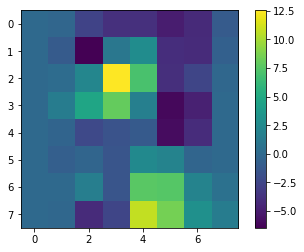

In [8]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(np.mean(get_class(images, target, 1), axis=0) - np.mean(get_class(images, target, 7), axis=0))
plt.colorbar(im)
plt.show()

One can recognize, that pixels (2,3), (2,4), (3,3) as well as pixels (6,4), (6,5), (7,4), (7,5) are often populated in a 1 whereas pixels (1,2), (3,5), (4,5) and (7,2) are often populated in a 7.

In [9]:
pixels_1 = [(2,3,3), (2,4,.5), (3,3,.5), (6,4,0.5), (6,5,0.5)]
pixels_7 = [(1,2,1.5), (3,5,1.5), (4,5,1), (0,5,0.5)]

def flat_ind(index):
    return np.ravel_multi_index(index, (8, 8))

def reduce_dim(x):
    reduced = np.empty((x.shape[0], 2))
    # first feature is large for a 1
    reduced[:,0] = np.sum([pixel[2]*x[:,flat_ind(pixel[:2])] for pixel in pixels_1], axis=0)
    # second feature is large for a 7
    reduced[:,1] = np.sum([pixel[2]*x[:,flat_ind(pixel[:2])] for pixel in pixels_7], axis=0)
    return reduced

## Validation of feature choice

In [10]:
X_all_r = reduce_dim(X_all)

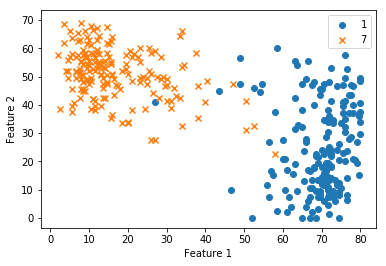

In [13]:
fig, ax = plt.subplots(1, 1)
# plot the 1's
ax.scatter(get_class(X_all_r, y_all, 1)[:,0], get_class(X_all_r, y_all, 1)[:,1], marker='o', label="1")
# plot the 7's
ax.scatter(get_class(X_all_r, y_all, 7)[:,0], get_class(X_all_r, y_all, 7)[:,1], marker='x', label="7")
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.legend()
plt.show()

Not to good, as required :D

# Question 2: Nearest Mean Classifier

In [14]:
def nearest_mean(training_features, training_labels, test_features):
    """
    This function implements the nearest mean classifier
    """
    # calculating the mean of feature 1 and feature 2 for the training set of digit 1
    mean_1 = np.mean(get_class(training_features, training_labels, 1), axis = 0)
    # calculating the mean of feature 1 and feature 2 for the training set of digit 7
    mean_7 = np.mean(get_class(training_features, training_labels, 7), axis = 0)
    
    # create distance matrix
    distances = np.empty_like(test_features)
    
    distances[:,0] = np.sqrt(np.sum([(test_features[:,i] - mean_1[i])**2 for i in range(2)], axis=0)) # distance to cluster 1
    distances[:,1] = np.sqrt(np.sum([(test_features[:,i] - mean_7[i])**2 for i in range(2)], axis=0)) # distance to cluster 7
    
    # create prediction
    prediction = np.empty((test_features.shape[0]), dtype=float)
    prediction[:] = 1 # set all to label 1
    # if distance to 7 is smaller: set to label 7
    prediction[distances[:,0] > distances[:,1]] = 7
    
    return prediction

## Visualisation of decision regions

For this exercise we need a training and a test set.

In [18]:
X_train_r , X_test_r , y_train , y_test = cross_validation.train_test_split(X_all_r, y_all, test_size=0.4, random_state=0)

In [19]:
# creeate a grid
grid_feat_1 = np.linspace(np.min(X_all_r[:,0]), np.max(X_all_r[:,0]), 300)
grid_feat_2 = np.linspace(np.min(X_all_r[:,1]), np.max(X_all_r[:,1]), 300)
# thanks to SO
grid = np.transpose([np.tile(grid_feat_1, len(grid_feat_2)), np.repeat(grid_feat_2, len(grid_feat_1))])

In [21]:
# apply classifier
grid_prediction = nearest_mean(X_train_r, y_train, grid)
test_prediction = nearest_mean(X_train_r, y_train, X_test_r)

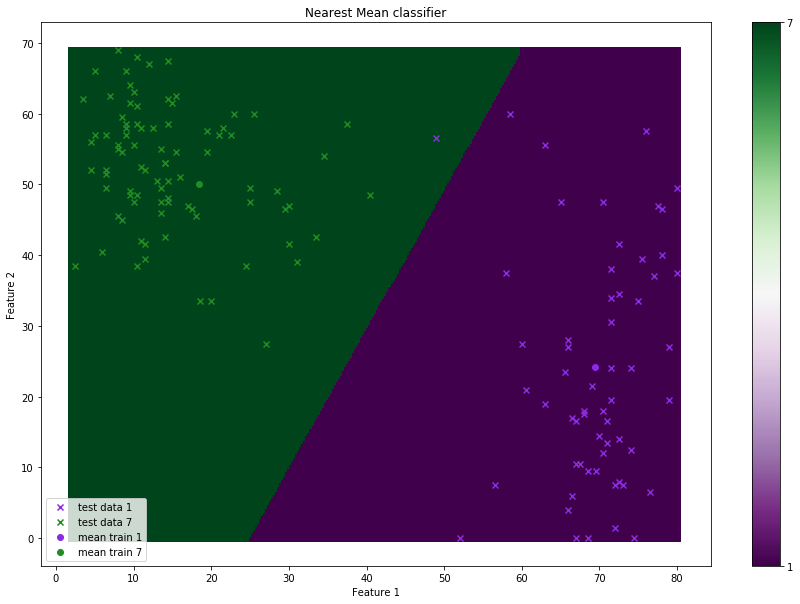

In [23]:
# plot that stuff

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# plot the decision region
scat = ax.scatter(grid[:,0], grid[:,1], c=grid_prediction, marker='s', cmap='PRGn')
cbar = plt.colorbar(scat, ticks=[1, 7])
# plot the test data
ax.scatter(get_class(X_test_r, y_test, 1)[:,0], get_class(X_test_r, y_test, 1)[:,1], marker='x', color='blueviolet', label="test data 1")
ax.scatter(get_class(X_test_r, y_test, 7)[:,0], get_class(X_test_r, y_test, 7)[:,1], marker='x', color='forestgreen', label="test data 7")
# plot the means for 1 and 7, yeah well nice syntax :D
ax.scatter(*np.mean(get_class(X_train_r, y_train, 1), axis = 0), marker='o', color='blueviolet', label="mean train 1")
ax.scatter(*np.mean(get_class(X_train_r, y_train, 7), axis = 0), marker='o', color='forestgreen', label="mean train 7")
# labelling
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Nearest Mean classifier')
ax.legend(loc=3)
plt.show()

# Question 3: QDA

## Implementation of fitting

In [24]:
def fit_qda(training_features, training_labels, possible_features=[1, 7]):
    D = training_features.shape[1] # dimension of features
    F = len(possible_features) # number of features we are dealing with
    
    # create an array of testsetdata, corresponds to possible features
    ts = [get_class(training_features, training_labels, feature) for feature in possible_features]
    # caculate the total amount of testdata (including all possible features)
    N_tot = sum([tsf.shape[0] for tsf in ts])

    # mu has the shape FxD
    mu = np.empty((F, D), dtype=float)
    # cov should have the shape FxDxD
    cov = np.empty((F, D, D))
    # the priors are scalars and have therefore the shape F
    p = np.empty(F)
    
    for i in range(F):
        N = ts[i].shape[0] # number of training instances for the feature possible_feature[i]
        # calculating mu
        mu[i] = np.mean(ts[i], axis=0)
    
        # calculating the covariance matrix
        ts_centralised = ts[i] - mu[i]
        # some numpy magic
        cov[i] = np.add.reduce(ts_centralised[:,:,np.newaxis] * ts_centralised[:,np.newaxis,:])/N
    
        # calculating the priors
        p[i] = N/N_tot
        
    # done
    return mu, cov, p


## Prediction

In [25]:
def predict_pda(mu, covmat, p, test_features, possible_features = [1, 7]):
    # numpy array to store the results for each k
    results = np.empty((len(possible_features), test_features.shape[0]))
    
    # for each class
    for i in range(len(possible_features)):
        # calculating b_k
        bk = np.log(np.linalg.det(covmat[i])) - 2*np.log(p[i])
        
        # calculating the inverse of the cov-matrix
        sig_inv = np.linalg.inv(covmat[i])
        # centralise the coordinates
        centralised = test_features - mu[i]
        # calculate the Mohalunsbis-distance with some numpy magic
        moha_dist = np.sum(centralised * np.tensordot(sig_inv, centralised, (1, 1)).T, axis=1)
        # store the result
        results[i] = moha_dist + bk
    
    # minimize the results
    minimized = np.argmin(results, axis = 0)
    
    # this will hold the actual label instead of its index in possible_features
    test_labels = np.empty(test_features.shape[0])
    # populate this stuff
    for i, k in enumerate(possible_features):
        test_labels[minimized == i] = k
    
    return test_labels


def get_error_rate(a, b):
    # yep, you know...
    return np.count_nonzero(a - b)/a.shape[0]

### Fitting with training data 

I guess we are supposed to train with the complete data set since we are applying crossvalidation later.

In [26]:
mu, covmat, p = fit_qda(X_all_r, y_all)

In [27]:
# apply to test set, training set and grid
grid_pred_qda = predict_pda(mu, covmat, p, grid)
train_pred_qda = predict_pda(mu, covmat, p, X_all_r)

## Visualisation

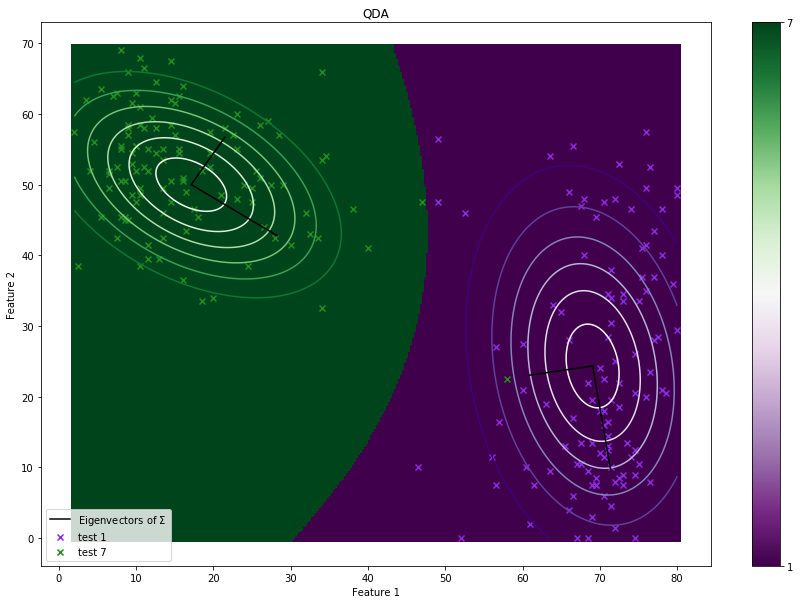

In [22]:
# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# plot the decision region
scat = ax.scatter(grid[:,0], grid[:,1], c=grid_pred_qda, marker='s', cmap='PRGn')
cbar = plt.colorbar(scat, ticks=[1, 7])
# plot the training
ax.scatter(get_class(X_all_r, y_train, 1)[:,0], get_class(X_train_r, y_train, 1)[:,1], marker='x', color='blueviolet', label="test 1")
ax.scatter(get_class(X_all_r, y_train, 7)[:,0], get_class(X_train_r, y_train, 7)[:,1], marker='x', color='forestgreen', label="test 7")

#plot the gaussians
mesh_feat1, mesh_feat2 = np.meshgrid(grid_feat_1, grid_feat_2)
gauss_1 = multivariate_normal.pdf(grid, mean=mu[0], cov=covmat[0])
gauss_2 = multivariate_normal.pdf(grid, mean=mu[1], cov=covmat[1])
cg1 = ax.contour(mesh_feat1, mesh_feat2, gauss_1.reshape(300, 300), cmap='Purples_r')
#plt.clabel(cg1, inline=1, fontsize=10)
cg2 = ax.contour(mesh_feat1, mesh_feat2, gauss_2.reshape(300, 300), cmap='Greens_r')
#plt.clabel(cg2, inline=1, fontsize=10)

# eigenvalue decomposition
e_val_1, e_vec_1 = np.linalg.eig(covmat[0])
e_val_2, e_vec_2 = np.linalg.eig(covmat[1])
# for label 1
ax.plot([mu[0, 0], mu[0, 0] + np.sqrt(e_val_1[0])*e_vec_1[0, 0]], [mu[0, 1], mu[0, 1] + np.sqrt(e_val_1[0])*e_vec_1[1, 0]], color='k', label='Eigenvectors of $\Sigma$')
ax.plot([mu[0, 0], mu[0, 0] + np.sqrt(e_val_1[1])*e_vec_1[0, 1]], [mu[0, 1], mu[0, 1] + np.sqrt(e_val_1[1])*e_vec_1[1, 1]], color='k')
# for label 7
ax.plot([mu[1, 0], mu[1, 0] + np.sqrt(e_val_2[0])*e_vec_2[0, 0]], [mu[1, 1], mu[1, 1] + np.sqrt(e_val_2[0])*e_vec_2[1, 0]], color='k')
ax.plot([mu[1, 0], mu[1, 0] + np.sqrt(e_val_2[1])*e_vec_2[0, 1]], [mu[1, 1], mu[1, 1] + np.sqrt(e_val_2[1])*e_vec_2[1, 1]], color='k')

# labelling
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('QDA')
ax.legend(loc=3)
plt.show()

There is only one missclassification in the training set (the 7 (green) inside the decision area for 1 (violet)). There are 109 instances of 1 and 114 instances of 7 in the training set, therefore the training error is $\frac{1}{109 + 114} = 0.4\%$.
In comparison to the Nearest Neighbour classifier, QDA does not use the training instances directly for classification, but the fitted Gaussian. Therefore outlayers of the cluster can be misclassified.

## Performance measure

In [ ]:
kf = KFold(n_splits=10)

# reduce all data and use only 1 and 7


for train, test in kf.split(X_all_fold):
    # fitting
    mu_fold, covmat_fold, p_fold = fit_qda(X_test_r, y_test)